# Gridworld with deep q-learning
### in reference to chapter 3 of "Deep Reinforcement Learning in Action" by Zai and Brown

#### 1. Instantiate a game of Gridworld

In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
# examples of moves
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.makeMove('l')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       ['P', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
# ask for current reward
game.reward()

-1

In [5]:
game.makeMove('u')
game.makeMove('u')
game.reward()

10

In [6]:
# return the array with the player (P), the goal (+), the pit(-), and the wall (W)
game.board.render_np()

array([[[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

### 2. Instantiate a feedforward network

In [7]:
# import necessary packages
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt

l1 = 64 # input layer 4 x 4 for one board, 4 boards for player, goal, pit and wall
l2 = 150 # first hidden layer
l3 = 100 # second hidden layer
l4 = 4 # output layer, the direction of next move

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

loss_fn = torch.nn.MSELoss() # define loss function 
learning_rate = 1e-3 # define a learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


gamma = 0.9 # discount factor
epsilon = 1.0 # define proability to steer exploit vs. exploration

##### Define a dictionary of moves

In [8]:
# dictionary of moves
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [9]:
epochs = 1000 # number of episodes for the game to be played
losses = [] # collect losses 
for i in range(epochs): # loop over epochs
    game = Gridworld(size=4, mode='static') # instantiate a game
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    state1 = torch.from_numpy(state_).float() #E
    status = 1 # flag for playing
    while(status == 1): # while game is ongoing
        qval = model(state1) # estimate of q-function
        qval_ = qval.data.numpy() # convert q-function to numpy-array
        if (random.random() < epsilon): # epsilon-greedy-strategy
            action_ = np.random.randint(0,4) # random action
        else:
            action_ = np.argmax(qval_) # best action in current state
        
        action = action_set[action_] # translate action to move via dictionary
        game.makeMove(action) # make move
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad(): # model should only learn from state 1, hence no_grad() for state2
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #M
        if reward == -1: # game is still ongoing
            Y = reward + (gamma * maxQ)
        else: # if reward is postive, game is over
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        
        loss = loss_fn(X.view(1), Y) # compare estimate of q-function with realized value
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2 # move environment to next state
        if reward != -1: # if reward is not -1, game is over
            status = 0
    if epsilon > 0.1: # reduce epsilon so that exploration is decreasing over time
        epsilon -= (1/epochs)

### 3. Define function to test whether algorithm has learned to play Gridworld

In [10]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): # game is ongoing
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) # choose best action
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

### 4. Plot loss function

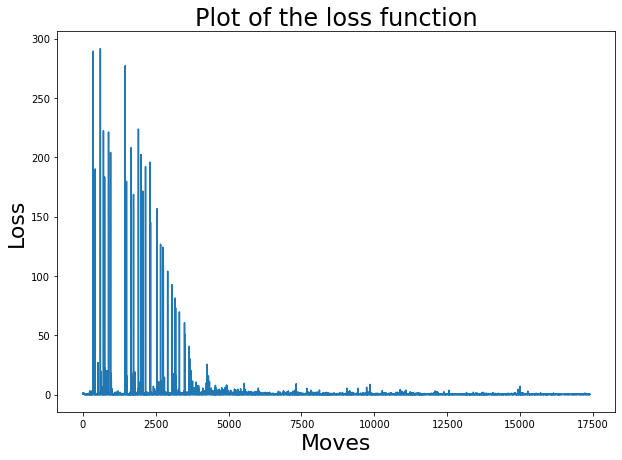

In [11]:
plt.figure(figsize=(10,7))
plt.title("Plot of the loss function", fontsize=24)
plt.plot(losses)
plt.xlabel("Moves",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.show()

### 5. Test the model

In [12]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True